In [38]:
#import os
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import pickle
from PIL import Image
from numpy import asarray


In [39]:
# find and read image
images_dir = cv2.imread("/Users/atemkuh/Documents/GitHub/Mask-Finder/data/with_mask/0.jpg")

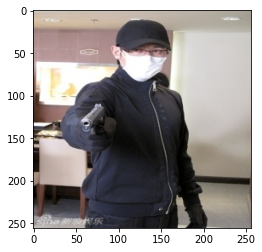

In [40]:
#view image and convert into RGB using cv2
plt.imshow(cv2.cvtColor(images_dir, cv2.COLOR_BGR2RGB))

In [41]:
#images_dir.shape

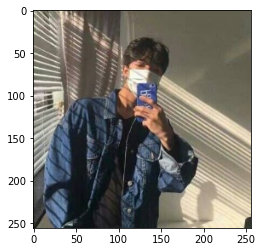

In [42]:
#loop through dataset
Images_directory = "/Users/atemkuh/Documents/GitHub/Mask-Finder/data"
Classes = ["with_mask","without_mask"]
for category in Classes:
    path = os.path.join(Images_directory, category)
    for img in os.listdir(path):
        images_dir = cv2.imread(os.path.join(path,img))
        
        plt.imshow(cv2.cvtColor(images_dir, cv2.COLOR_BGR2RGB))
        plt.show()
        # stop processing after first image
        break
    break
    

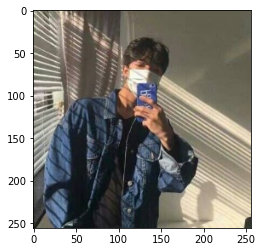

In [43]:
#resize images using imageNet 
img_size = 224
new_img_array=cv2.resize(images_dir,(img_size,img_size))
plt.imshow(cv2.cvtColor(images_dir, cv2.COLOR_BGR2RGB))
plt.show()


In [44]:
# convert images to arrays 
training_data = []

def create_training_data():
    for category in Classes:
        path = os.path.join(Images_directory,category)
        class_num = Classes.index(category)
        
        print("category")
        for img in os.listdir(path):
            try:
               # print(img, ", ", path)
                images_dir    = cv2.imread(os.path.join(path,img))
                
                new_img_array = cv2.resize(images_dir,(img_size,img_size))
                
                training_data.append([new_img_array, class_num])
              #  print(len(training_data))
                
            except Exception as e:
                print(e)
                
                
    

In [45]:
create_training_data()

category
category


In [46]:
print(len(training_data))

11042


In [47]:
random.shuffle(training_data)

In [48]:
X =[]
y=[]

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1,img_size,img_size,3)

In [49]:
X.shape

(11042, 224, 224, 3)

In [50]:
Y=np.array(y)

In [51]:
#pickle x
pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()
#pickle y
pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [52]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [53]:
#create and train deep learning model
#pre trained model
model = tf.keras.applications.MobileNet()
model.summary() #Total params: 4,253,864

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [54]:
# use existing solution by implementing transfer learning "tuning", "weights"
base_input = model.layers[0].input
base_output = model.layers[-4].output
Flatten_layer =  layers.Flatten()(base_output)
#classifier  can either be 0 or 1
final_output = layers.Dense(1)(Flatten_layer)
final_output = layers.Activation('sigmoid')(final_output)
#new model

new_model=keras.Model(inputs = base_input, outputs = final_output)
new_model.summary()## display the sum of the new model #Total params: 3,229,889

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [55]:
#setup up configuration os classes('with_mask','without_mask')

#compile new model
new_model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [56]:
new_model.fit (X,Y, epochs = 5, validation_split = 0.1)

Train on 9937 samples, validate on 1105 samples
Epoch 1/5
9937/9937 [==============================] - 1683s 169ms/sample - loss: 0.0461 - accuracy: 0.9844 - val_loss: 0.0470 - val_accuracy: 0.9937
Epoch 2/5
9937/9937 [==============================] - 1565s 157ms/sample - loss: 0.0102 - accuracy: 0.9975 - val_loss: 0.0200 - val_accuracy: 0.9946
Epoch 3/5
9937/9937 [==============================] - 1547s 156ms/sample - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.0892 - val_accuracy: 0.9810
Epoch 4/5
9937/9937 [==============================] - 2135s 215ms/sample - loss: 0.0096 - accuracy: 0.9966 - val_loss: 0.0077 - val_accuracy: 0.9964
Epoch 5/5
9937/9937 [==============================] - 1516s 153ms/sample - loss: 0.0129 - accuracy: 0.9962 - val_loss: 0.0327 - val_accuracy: 0.9819


In [57]:
#save model
new_model.save('new_model.h5')

In [58]:
#import trained model using tf.keras.models.load_model
new_model = tf.keras.models.load_model('new_model.h5')

In [73]:
#predictions with mask
frame = cv2.imread('demo_mask.jpg')

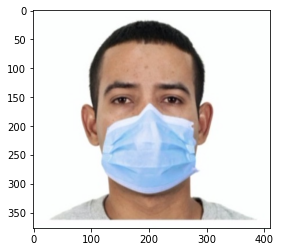

In [74]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [65]:
final_img =cv2.resize(frame,(224,224))
final_img =np.expand_dims(final_img, axis=0)
final_img = final_img/255.0

In [66]:
Predictions = new_model.predict(final_img)
Predictions

array([[0.01689249]], dtype=float32)

In [75]:
frame=cv2.imread('demo_without_mask.jpg')

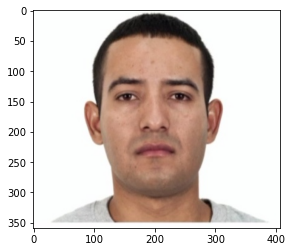

In [76]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [77]:
#get Haar feature detector
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
#convert image from BGR to gray
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
gray

array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8)

In [78]:
# to detect faces

face = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in face:
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame,(x,y),(x+w, y+h), (0,255,0),2)
    faces = faceCascade.detectMultiScale(roi_gray)
    if len(faces)==0:
        print("No Face Detected")
    else:
        for (ex,ey,ew,eh) in faces:
            face_roi = roi_color[ey: ey+eh,ex:ex+ew]

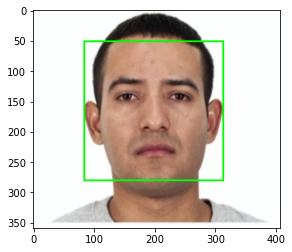

In [79]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

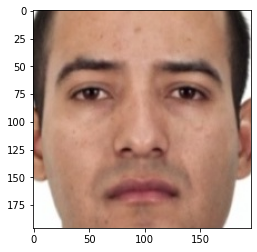

In [80]:
# crop face
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))

In [81]:
final_img =cv2.resize(frame,(224,224))
final_img =np.expand_dims(final_img, axis=0)
final_img = final_img/255.0
Predictions = new_model.predict(final_img)
Predictions

array([[0.01700304]], dtype=float32)

In [84]:
path = "haarcascade_frontalface_default.xml"
font_scale=1.5
font = cv2.FONT_HERSHEY_PLAIN

rectangle_bgr = (255,255,255)
img = np.zeros((500,500))
text="some. text in a box!"#text in a box
#width and height
(text_width, text_height) = cv2.getTextSize(text,font,fontScale=font_scale, thickness=1)[0]
#set text position

text_offset_x = 10
text_offset_y = img.shape[0]-25

#box coords

box_coords =((text_offset_x, text_offset_y),(text_offset_x+text_width+2,text_offset_y - text_height - 2))
cv2.rectangle (img,box_coords[0], box_coords[1],rectangle_bgr, cv2.FILLED)
cv2.putText(img,text,(text_offset_x, text_offset_y), font, fontScale=font_scale, color = (0,0,0), thickness = 1)
#setup video capture
cap = cv2.VideoCapture(1)
if not cap.isOpened():
    cap = cv2.VideoCapture(0)#number of camera 0 for one camera present
if not cap.isOpened():
    raise IOError("Please check camera or webcam")

while True:
    
    ret,frame = cap.read()
    
    faceCascade =cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    face = faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in face:
        roi_gray=gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),2)
        faces = faceCascade.detectMultiScale(roi_gray)
        if len(faces)==0:
            print ("No face detected")
        else:
            # crop our region of interest (ROI)
            for (ex,ey,ew,eh) in faces:
                face_roi in roi_color[ey: ey+eh, ex:ex+ew]
                
    final_image = cv2.resize(face_roi,(224,224))
    final_image= np.expand_dims(final_image,axis =0)
    final_image=final_image/255.0
    font=cv2.FONT_HERSHEY_SIMPLEX
    Predictions = new_model.predict(final_image)
    font_scale=1.5
    font=cv2.FONT_HERSHEY_PLAIN
    
    if (Predictions>0):
        status = "NO Mask"
        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame, (x1,x1),(x1+w1,y1+h1), (0,0,0), -1)
        cv2.putText (frame,status, (x1+int(w1/10),y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX,0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y),(x+w,y+h),(0,0,255))
    else:
        status = "Face Mask"
        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame, (x1,x1),(x1+w1,y1+h1), (0,0,0), -1)
        cv2.putText (frame,status, (x1+int(w1/10),y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX,0.7, (0,255,0),2)
        cv2.putText(frame,status,(100,150),font,3,(0,255,0),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y),(x+w,y+h),(0,0,255))
        
        cv2.imshow('Mask Finder', frame)
        if cv2.waitKey(1)& 0xFF ==ord('q'):
            break
        cap.release()
        cv2.destroyAllWindows()
        
            
    #     

2021-02-28 12:03:31,134 [832] WARNING  py.warnings:99: [JupyterRequire] /Users/atemkuh/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



No face detected
No face detected
No face detected
No face detected
No face detected
No face detected


KeyboardInterrupt: 